In [1]:
%load_ext lab_black

import requests
import pandas as pd
import numpy as np
import tqdm
import pickle
import mplfinance as mpf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, date, time
from sklearn.linear_model import LinearRegression

pd.set_option("max_columns", 99)
pd.options.display.float_format = "{:.12f}".format


Bad key "text.kerning_factor" on line 4 in
/home/paul/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
df = pd.read_pickle("rebalance_data/all_rebalances.pkl")

In [3]:
df = df.loc[
    (df["time"].dt.time >= time(0, 2, 0)) & (df["time"].dt.time <= time(0, 3, 30))
].sort_values("time")

df["date"] = df.time.dt.date
df["directional_size"] = np.where(df.side == "sell", df.filledSize * -1, df.filledSize)
df["directional_notional"] = df.directional_size * df.avgFillPrice

In [4]:
df_totals = df.groupby(["date", "underlying"]).directional_notional.sum().reset_index()
df_totals["abs_notional"] = abs(df_totals["directional_notional"])

In [5]:
df_totals = df_totals[df_totals["date"] >= date(2021, 4, 16)]
df_totals = df_totals[~df_totals.underlying.isin(["ETH-PERP", "BTC-PERP"])]

In [6]:
df_totals.sort_values("abs_notional", ascending=False)

,date,underlying,directional_notional,abs_notional
18002,2021-05-13,EOS-PERP,-19444358.339800000191,19444358.339800000191
18279,2021-05-20,EOS-PERP,-15916658.804150000215,15916658.804150000215
17738,2021-05-06,LTC-PERP,14532752.005300000310,14532752.005300000310
18439,2021-05-24,EOS-PERP,-12673105.359475001693,12673105.359475001693
17305,2021-04-25,EOS-PERP,-11756147.240225000307,11756147.240225000307
...,...,...,...,...
23871,2021-10-04,DEFI-PERP,0.012800000000,0.012800000000
24202,2021-10-12,DEFI-PERP,0.012600000000,0.012600000000
29290,2022-02-07,XAUT-PERP,0.008000000000,0.008000000000
21794,2021-08-15,DEFI-PERP,0.003000000000,0.003000000000


In [7]:
df_totals.underlying.unique()

array(['ALT-PERP', 'ASD-PERP', 'ATOM-PERP', 'BAL-PERP', 'BCH-PERP',
       'BNB-PERP', 'BSV-PERP', 'COMP-PERP', 'DEFI-PERP', 'DOGE-PERP',
       'DRGN-PERP', 'EOS-PERP', 'ETC-PERP', 'EXCH-PERP', 'GRT-PERP',
       'HT-PERP', 'KNC-PERP', 'LEO-PERP', 'LINK-PERP', 'LTC-PERP',
       'MATIC-PERP', 'MID-PERP', 'MKR-PERP', 'PAXG-PERP', 'PRIV-PERP',
       'SHIT-PERP', 'SUSHI-PERP', 'SXP-PERP', 'THETA-PERP', 'TOMO-PERP',
       'TRX-PERP', 'TRYB-PERP', 'USDT-PERP', 'VET-PERP', 'XAUT-PERP',
       'XRP-PERP', 'XTZ-PERP', 'ZEC-PERP', 'OKB-PERP', 'UNISWAP-PERP',
       'ALGO-PERP', 'ADA-PERP', 'CUSDT-PERP', 'XLM-PERP', 'BTC-MOVE-0422'],
      dtype=object)

In [8]:
df_totals[df_totals.underlying == "BNB-PERP"].sort_values(
    "abs_notional", ascending=False
)

,date,underlying,directional_notional,abs_notional
18272,2021-05-20,BNB-PERP,-4212310.242500000633,4212310.242500000633
17221,2021-04-23,BNB-PERP,-3095201.767750000115,3095201.767750000115
18432,2021-05-24,BNB-PERP,-2631019.990000000224,2631019.990000000224
18352,2021-05-22,BNB-PERP,-2527789.967499999795,2527789.967499999795
17995,2021-05-13,BNB-PERP,-2320332.154250000138,2320332.154250000138
...,...,...,...,...
21790,2021-08-15,BNB-PERP,-1352.323500000000,1352.323500000000
24978,2021-10-31,BNB-PERP,-1323.756250000000,1323.756250000000
19227,2021-06-13,BNB-PERP,1269.541750000000,1269.541750000000
25518,2021-11-13,BNB-PERP,-1068.169500000000,1068.169500000000


In [9]:
_date = date(2021, 5, 20)
_under = "BNB-PERP"

In [10]:
df_under = pd.read_csv(f"candle_data/{_under}.csv")
df_under["time"] = pd.to_datetime(df_under["time"])
df_under.sort_values("time", inplace=True)

In [11]:
df_under = df_under[df_under["time"] >= (_date - pd.DateOffset(minutes=15))]
df_under = df_under[df_under["time"] <= (_date + pd.DateOffset(minutes=15))]

df_under.rename(
    {
        "open": "Open",
        "high": "High",
        "low": "Low",
        "close": "Close",
        "volume": "Volume",
    },
    axis=1,
    inplace=True,
)

df_under.set_index("time", inplace=True)

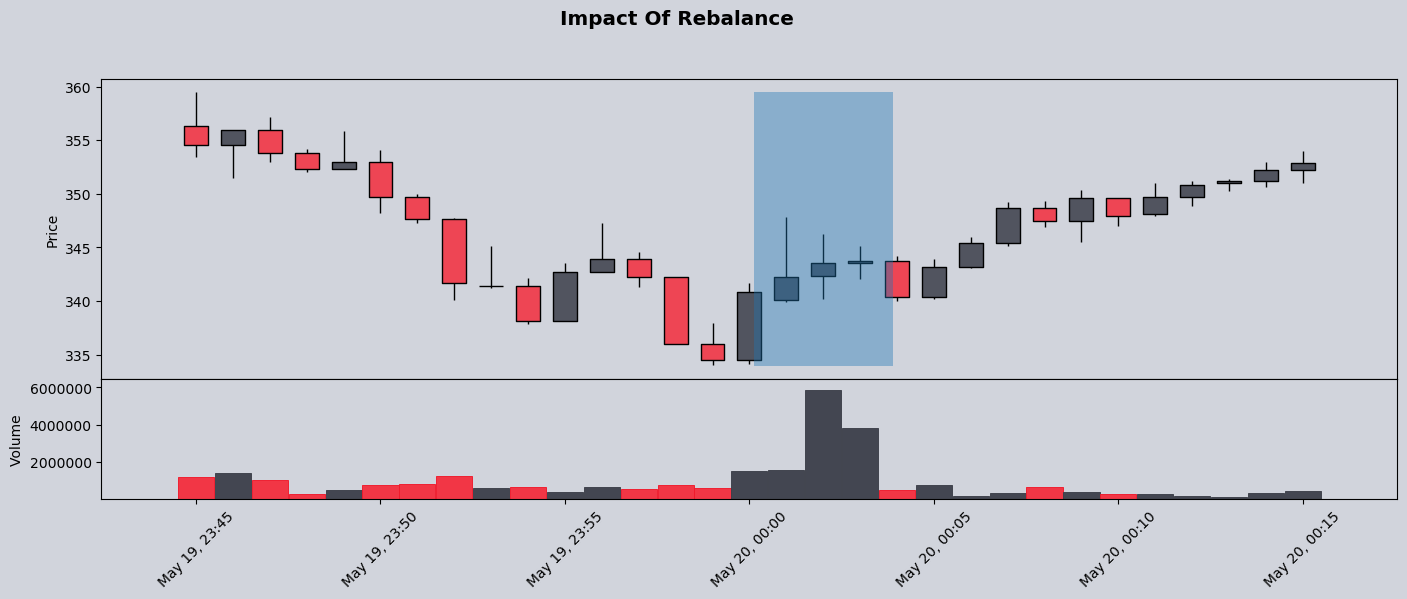

In [12]:
mc = mpf.make_marketcolors(
    up="#434651", down="#f23645", edge="black", wick="black", volume="in", ohlc="i",
)
s = mpf.make_mpf_style(marketcolors=mc, figcolor="#d1d4dc", facecolor="#d1d4dc",)

mpf.plot(
    df_under,
    type="candle",
    volume=True,
    vlines=dict(
        vlines=[str(_date + pd.DateOffset(minutes=2)),], linewidths=(100, 1), alpha=0.4
    ),
    style=s,
    figsize=(18, 6),
    title="Impact Of Rebalance",
)

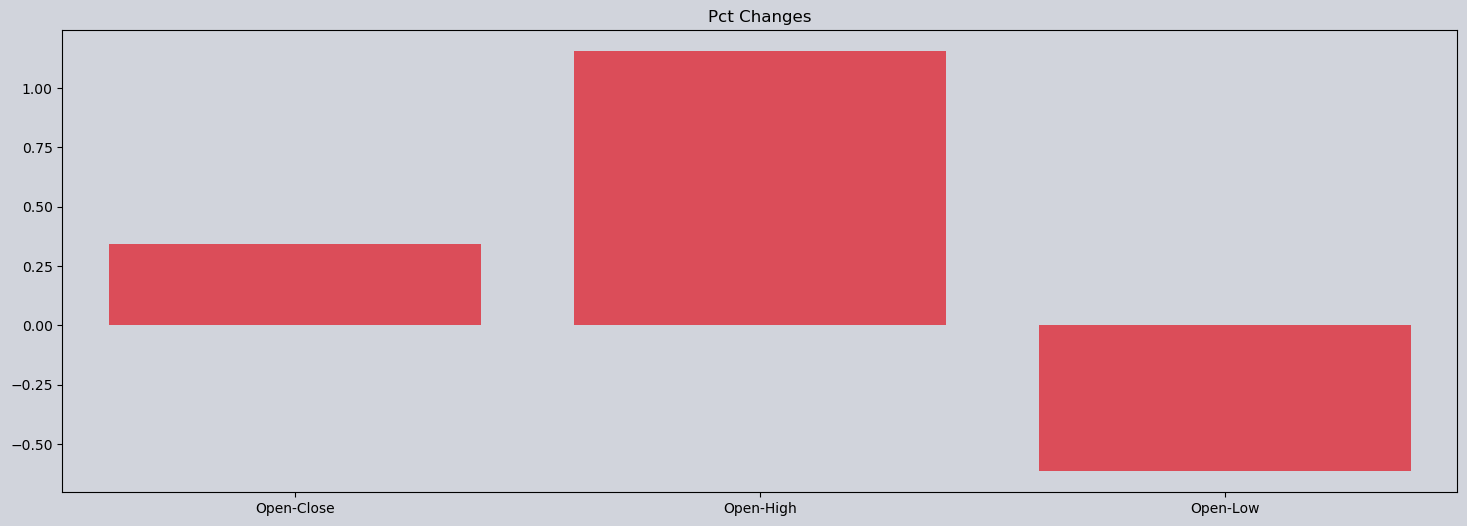

In [13]:
fig, ax = plt.subplots(figsize=(18, 6))
_open = df_under[df_under.index == (_date + pd.DateOffset(minutes=2))].Open
_close = df_under[df_under.index == (_date + pd.DateOffset(minutes=2))].Close
_high = df_under[df_under.index == (_date + pd.DateOffset(minutes=2))].High
_low = df_under[df_under.index == (_date + pd.DateOffset(minutes=2))].Low


open_close_pct = (_close - _open) / _open * 100
open_high_pct = (_high - _open) / _open * 100
open_low_pct = (_low - _open) / _open * 100

results = {
    "Open-Close": open_close_pct,
    "Open-High": open_high_pct,
    "Open-Low": open_low_pct,
}

df_plot = pd.DataFrame(results)
sns.barplot(data=df_plot, color="#f23645").set_title("Pct Changes")

pass

## Simple Backtest

### Read and Clean all Candle Data

In [14]:
candle_master = pd.DataFrame()

for inst in tqdm.tqdm(df_totals.underlying.unique()):
    try:
        df_under = pd.read_csv(f"candle_data/{inst}.csv")
    except:
        continue

    df_under["time"] = pd.to_datetime(df_under["time"])
    df_under.sort_values("time", inplace=True)
    df_under["dt"] = df_under["time"]
    df_under["date"] = df_under["time"].dt.date
    df_under["time"] = df_under["time"].dt.time

    rebal_min = df_under[df_under.time == time(0, 2, 0)].copy()
    rebal_min["open_high_pct"] = (
        (rebal_min["high"] - rebal_min["open"]) / rebal_min["open"] * 100
    )

    rebal_min["open_low_pct"] = (
        (rebal_min["open"] - rebal_min["low"]) / rebal_min["open"] * 100
    )
    rebal_min = rebal_min[
        ["instrument", "date", "time", "open_high_pct", "open_low_pct"]
    ]

    candle_master = candle_master.append(rebal_min, ignore_index=True)

100%|██████████| 45/45 [00:26<00:00,  1.70it/s]


In [15]:
df_totals

,date,underlying,directional_notional,abs_notional
16946,2021-04-16,ALT-PERP,-33.622800000000,33.622800000000
16947,2021-04-16,ASD-PERP,13019.471936000000,13019.471936000000
16948,2021-04-16,ATOM-PERP,-6553.456760000000,6553.456760000000
16949,2021-04-16,BAL-PERP,-24.432300000000,24.432300000000
16950,2021-04-16,BCH-PERP,196354.754400000005,196354.754400000005
...,...,...,...,...
32524,2022-04-21,XAUT-PERP,840.779000000000,840.779000000000
32525,2022-04-21,XLM-PERP,-308766.816325000022,308766.816325000022
32526,2022-04-21,XRP-PERP,-1319372.586249999935,1319372.586249999935
32527,2022-04-21,XTZ-PERP,-163386.479467700003,163386.479467700003


In [16]:
rebalances = df_totals.copy()
rebalances.rename({"underlying": "instrument"}, inplace=True, axis=1)

In [17]:
impacts = rebalances.merge(
    candle_master, how="left", on=["instrument", "date"]
).dropna()

In [18]:
impacts["move"] = np.where(
    impacts.directional_notional < 0, impacts["open_low_pct"], impacts["open_high_pct"]
)

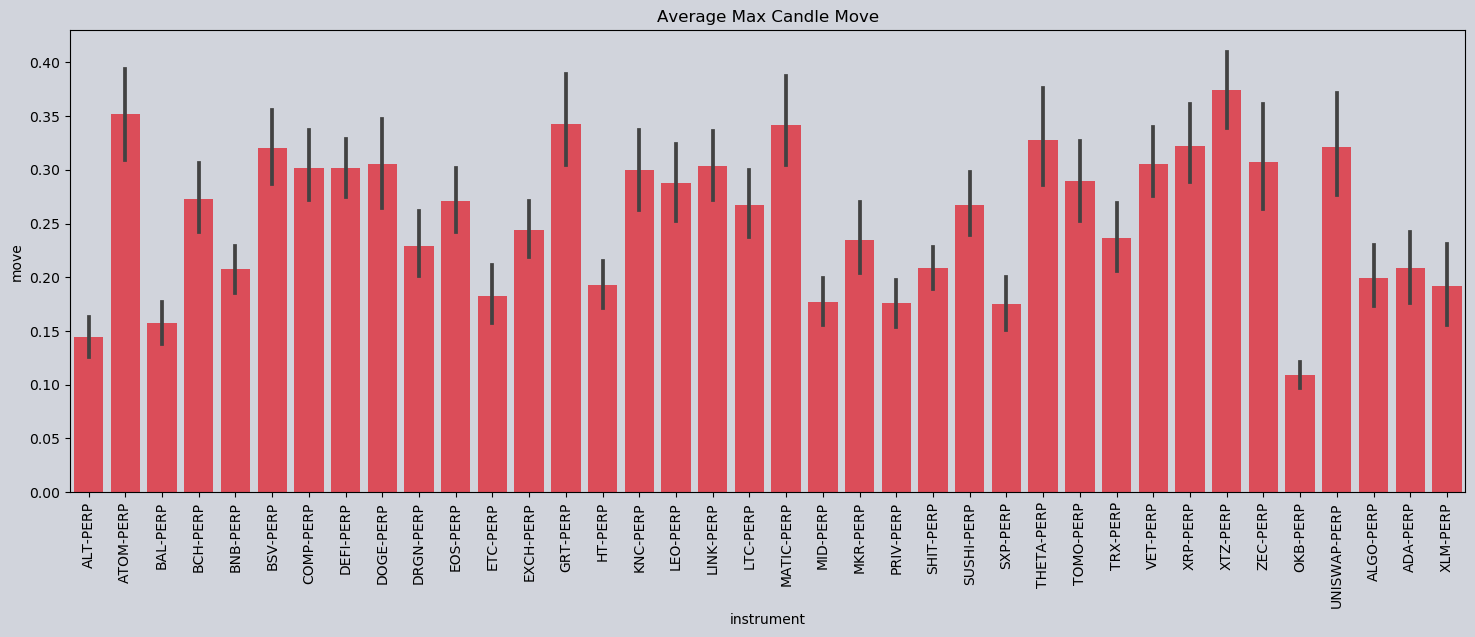

In [19]:
fig, ax = plt.subplots(figsize=(18, 6))
g = sns.barplot(data=impacts, x="instrument", y="move", color="#f23645")
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title("Average Max Candle Move")
pass

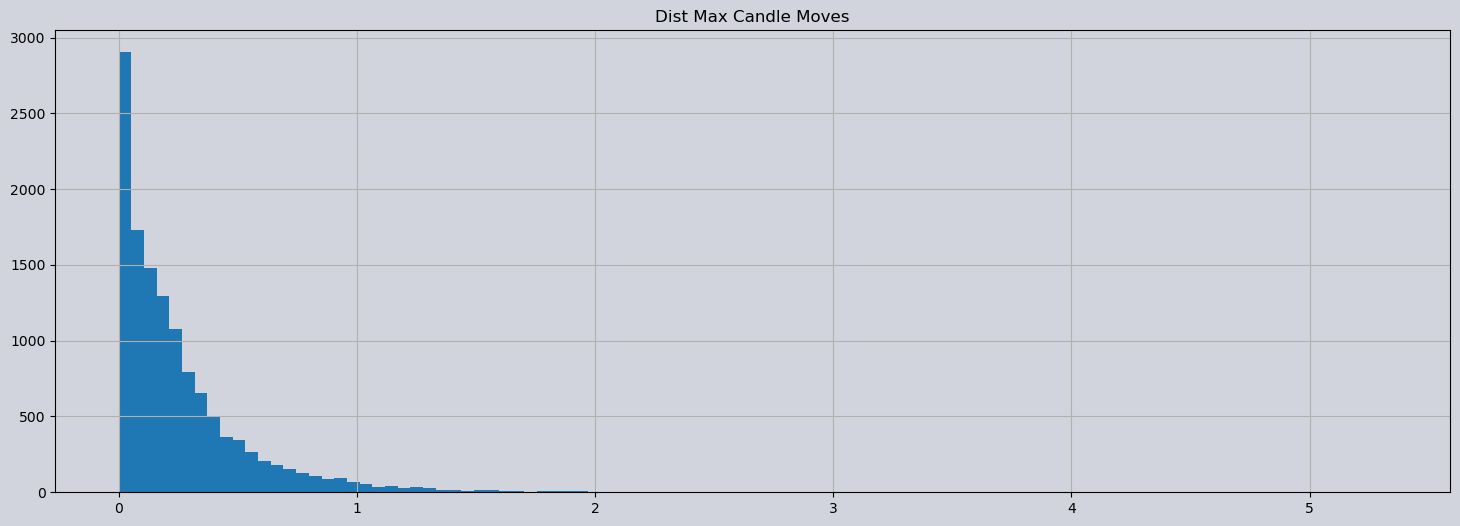

In [20]:
fig, ax = plt.subplots(figsize=(18, 6))
impacts.move.hist(bins=100)
ax.set_title("Dist Max Candle Moves")
pass

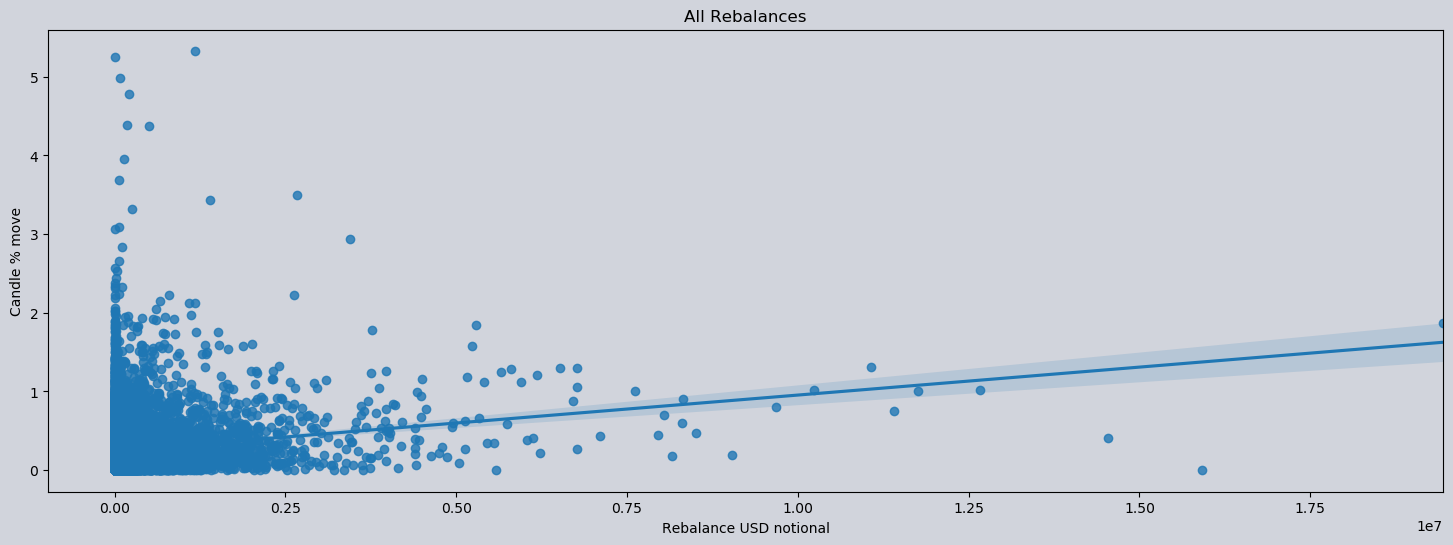

In [21]:
fig, ax = plt.subplots(figsize=(18, 6))
g = sns.regplot(data=impacts, x="abs_notional", y="move")
g.set_xlabel("Rebalance USD notional")
g.set_ylabel("Candle % move")
g.set_title("All Rebalances")
pass

In [22]:
def plot_inst_reg(inst):
    fig, ax = plt.subplots(figsize=(18, 6))
    data = impacts[(impacts.instrument == inst) & (impacts.abs_notional <= 3000000)]
    data = data[(data.abs_notional >= 100000)]
    data = data[(data.move < 3)]

    g = sns.regplot(data=data, x="abs_notional", y="move",)
    g.set_xlabel("Rebalance USD notional")
    g.set_ylabel("Candle % move")
    g.set_title(f"{inst}")

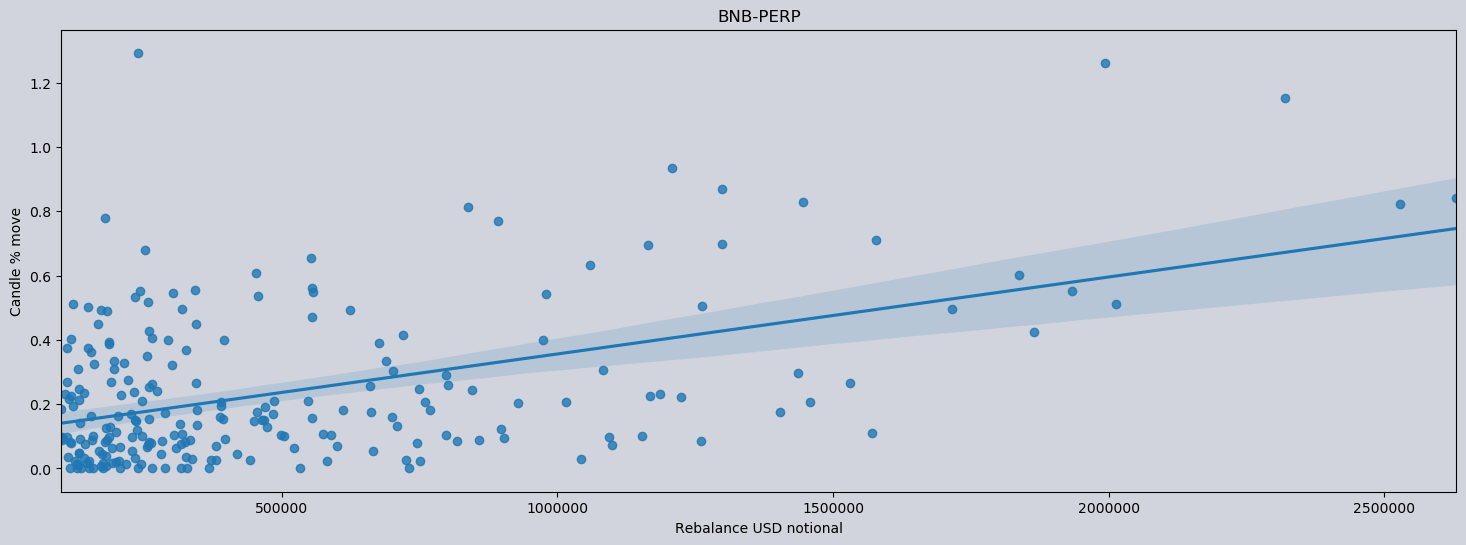

In [23]:
plot_inst_reg("BNB-PERP")

### Run all regressions

In [24]:
results = []
for inst in tqdm.tqdm(df_totals.underlying.unique()):
    data = impacts[(impacts.instrument == inst) & (impacts.abs_notional <= 3000000)]
    data = data[(data.abs_notional >= 100000)]
    data = data[(data.move < 3)]

    if data.shape[0] <= 20:
        continue

    lr = LinearRegression()
    lr.fit(data.abs_notional.values.reshape(-1, 1), data.move)
    results.append(
        {"instrument": inst, "intercept": lr.intercept_, "slope": lr.coef_[0]}
    )

100%|██████████| 45/45 [00:00<00:00, 545.86it/s]


In [25]:
pd.DataFrame(results).sort_values("slope", ascending=False).head(10)

,instrument,intercept,slope
18,THETA-PERP,0.025449389457,0.000001061338
15,MKR-PERP,0.331094466361,0.000000869410
5,DEFI-PERP,0.140264436781,0.000000478382
23,ZEC-PERP,0.206301990850,0.000000356014
10,GRT-PERP,0.263635462018,0.000000341246
14,MID-PERP,0.270814913729,0.000000326503
1,ATOM-PERP,0.073563398960,0.000000308711
22,XTZ-PERP,0.260674334217,0.000000297604
3,BNB-PERP,0.116739306784,0.000000239453
20,VET-PERP,0.256480221511,0.000000223860


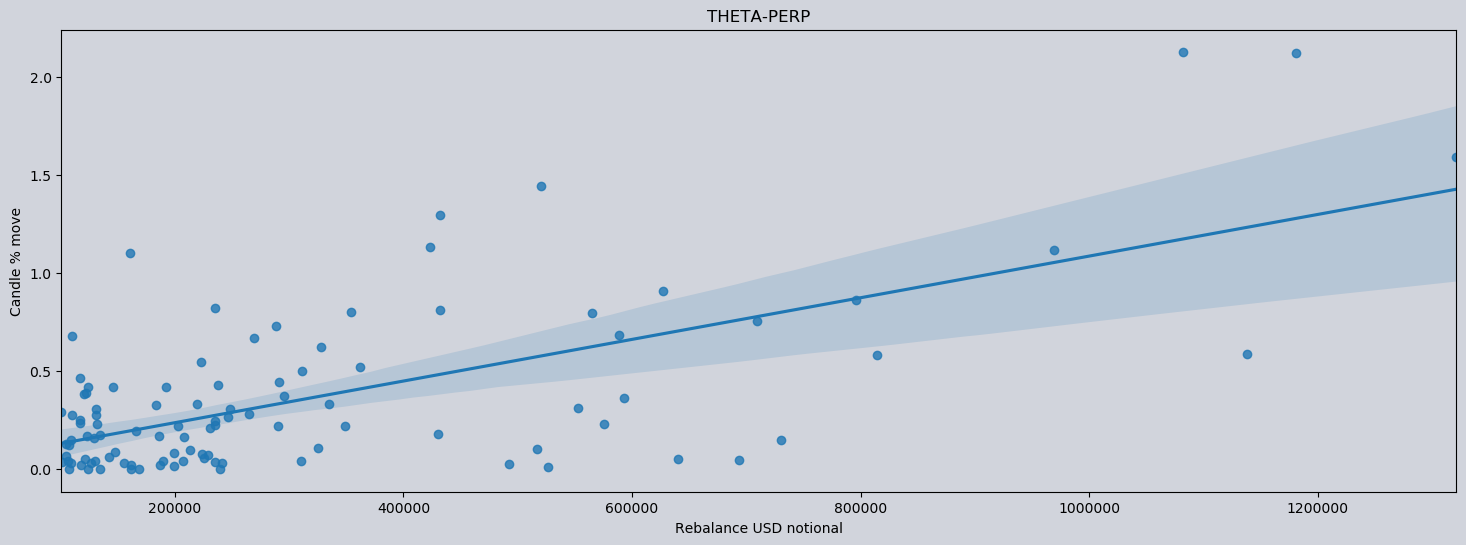

In [26]:
plot_inst_reg("THETA-PERP")

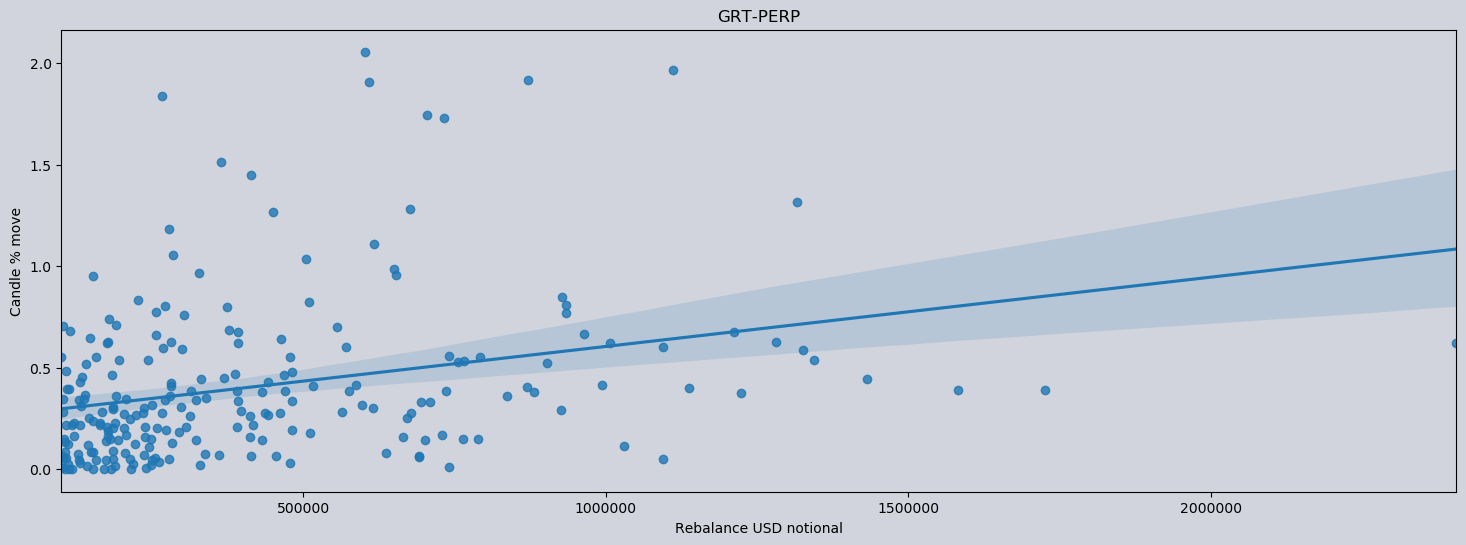

In [27]:
plot_inst_reg("GRT-PERP")

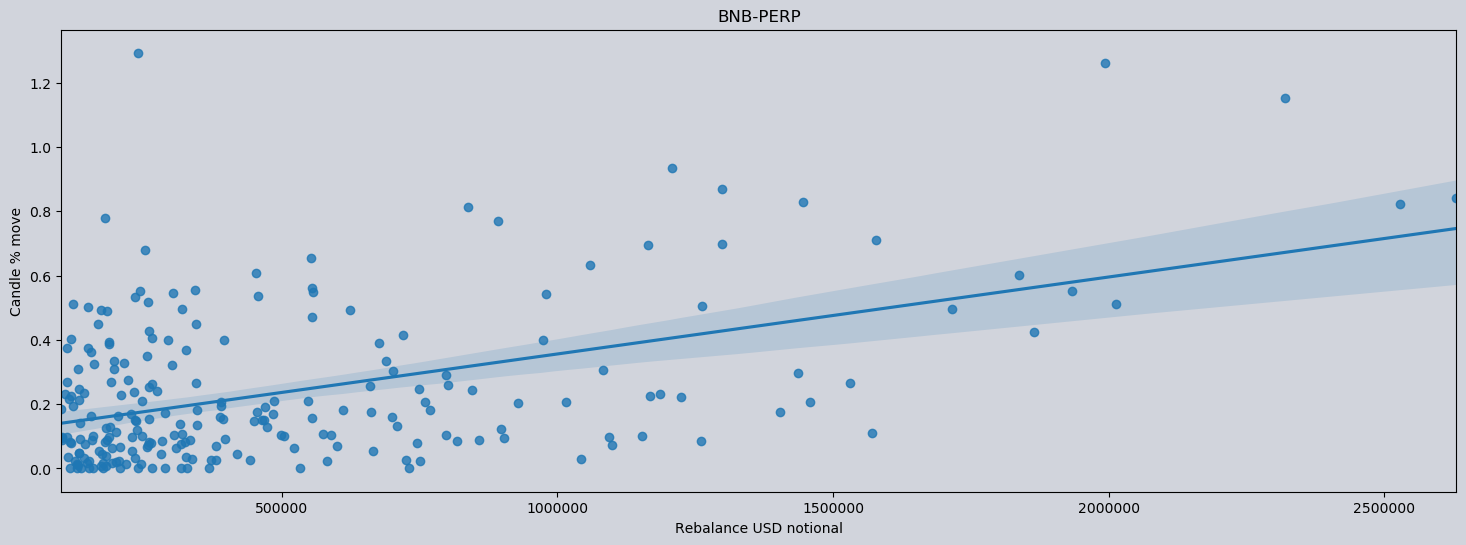

In [28]:
plot_inst_reg("BNB-PERP")